# Makemore Part 3

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [2]:
# read in all the words
words = open('../../data/names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
len(words)

32033

In [4]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [5]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):
  X, Y = [], []

  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [6]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g)
b1 = torch.randn(n_hidden,                        generator=g)
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0

parameters = [C, W1, W2, b2]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

11697


In [7]:
# same optimization as last time
max_steps = 20000
batch_size = 32
lossi = []

for i in range(max_steps):

    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

    # forward pass
    emb = C[Xb] # embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors

    # Linear layer
    # hidden pre-activation
    hpreact = embcat @ W1 + b1 # hidden layer pre-activation
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # loss function

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < max_steps //2 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 5000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

    break

      0/  20000: 3.3221


In [8]:
h.view(-1).tolist()

[0.8100222945213318,
 -0.8996702432632446,
 -0.999309241771698,
 0.9980825185775757,
 -0.6508485078811646,
 -0.6897538304328918,
 -0.9619210362434387,
 -0.9999876022338867,
 -0.3420684039592743,
 0.999920666217804,
 0.9999915957450867,
 -0.9980642199516296,
 0.9876819252967834,
 0.8998497128486633,
 0.8862370252609253,
 0.7360541820526123,
 -0.9959285855293274,
 -0.981837809085846,
 -0.989227294921875,
 0.9997955560684204,
 -0.9220333695411682,
 -0.8541557192802429,
 0.0639711245894432,
 0.9999996423721313,
 0.9979971051216125,
 -0.9949458837509155,
 0.9996280670166016,
 -0.9998515844345093,
 0.6444535255432129,
 0.7554441690444946,
 -0.9997296929359436,
 0.9996114373207092,
 0.9912618398666382,
 0.9449755549430847,
 0.9999983310699463,
 -0.9999998211860657,
 0.9999754428863525,
 -0.9999991059303284,
 1.0,
 -0.5565183758735657,
 0.9787917137145996,
 -0.9885085225105286,
 0.9983248710632324,
 -0.9999771118164062,
 -0.03651892766356468,
 0.9999677538871765,
 0.9990684986114502,
 -0.72501

Most values are either -1 or +1.

Inspect the absolute value of 'h' and see how often it is in a flat region (> 0.99).

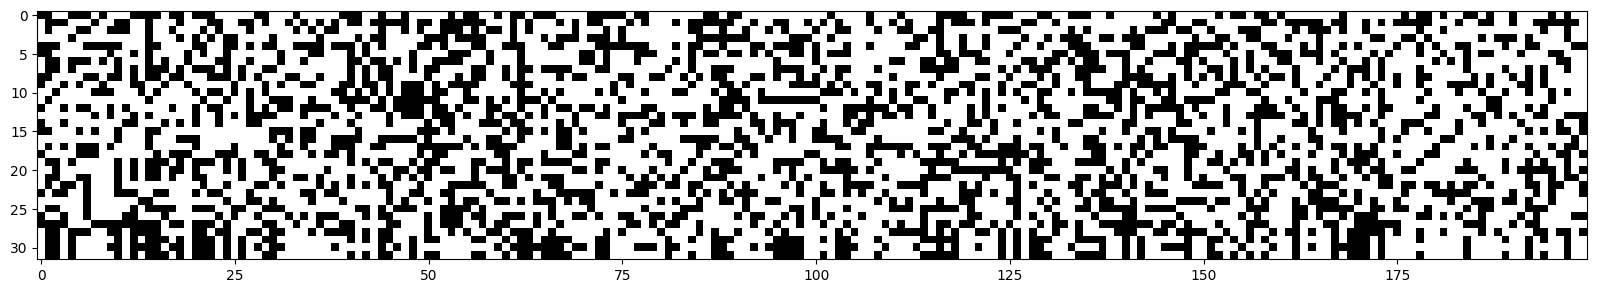

In [9]:
# 32 examples (y-axis) and 200 hidden neurons (x-axis)
# White: tanh neuron is very active and is in a flat tail (either at the top or the bottom).
# Backward gradient gets destroyed.
plt.figure(figsize=(20, 15))
plt.imshow(h.abs() > 0.99 , cmap='gray', interpolation='nearest')

We clearly see that the distribution is too saturated at the tails. This means that each neuron updates less frequently...

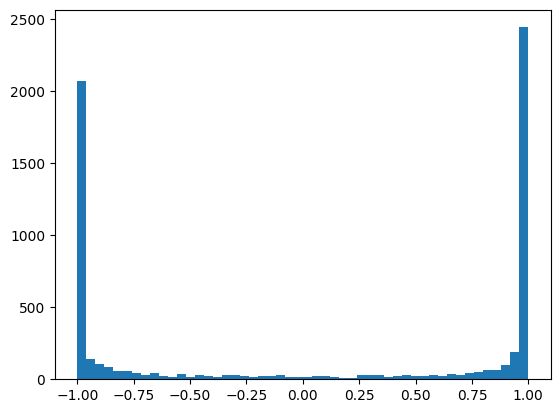

In [10]:
plt.hist(h.view(-1).tolist(), bins=50);

Distribution of pre-activations is very broad! Between - 15 and 15...

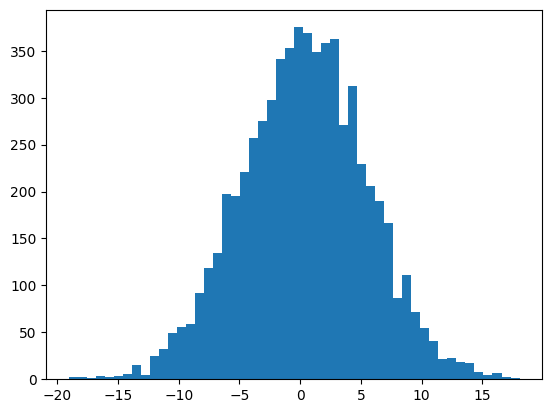

In [11]:
plt.hist(hpreact.view(-1).tolist(), 50);

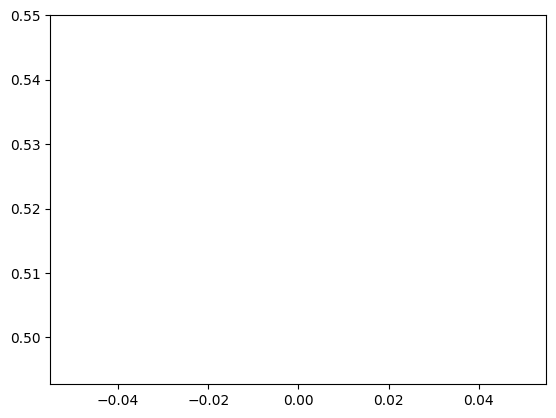

In [12]:
plt.plot(lossi)

In [13]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  h = torch.tanh(embcat @ W1 + b1) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 3.187894582748413
val 3.1877975463867188


## Changing our initialization

In [14]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * 0.02
b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0

parameters = [C, W1, W2, b2]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

11697


The mean of 'y' is close to zero. However, its standard deviation is much higher than that of the input (i.e., 3.16 vs 1.00!).

tensor(0.0027) tensor(1.0017)
tensor(0.0015) tensor(3.1157)


(array([2.18131601e-05, 1.45421068e-05, 3.63552669e-05, 5.81684270e-05,
        1.67234228e-04, 2.69028975e-04, 4.50805309e-04, 6.76207964e-04,
        1.17791065e-03, 2.34127919e-03, 3.47556351e-03, 5.83138481e-03,
        8.46350613e-03, 1.22444539e-02, 1.93337309e-02, 2.70410475e-02,
        3.89146777e-02, 5.20970975e-02, 7.08200599e-02, 9.02337724e-02,
        1.08993090e-01, 1.26705376e-01, 1.36259540e-01, 1.37262946e-01,
        1.31518814e-01, 1.13937406e-01, 9.66104862e-02, 7.68623053e-02,
        5.70632269e-02, 4.33791045e-02, 3.03275636e-02, 2.15732154e-02,
        1.39167962e-02, 9.50326677e-03, 6.15858221e-03, 3.98453725e-03,
        2.64666343e-03, 1.53419226e-03, 9.16152726e-04, 6.18039537e-04,
        3.63552669e-04, 1.67234228e-04, 1.09065801e-04, 3.63552669e-05,
        4.36263203e-05, 3.63552669e-05, 7.27105338e-06, 0.00000000e+00,
        0.00000000e+00, 7.27105338e-06]),
 array([-15.92138863, -15.23373035, -14.54607208, -13.85841381,
        -13.17075554, -12.4830

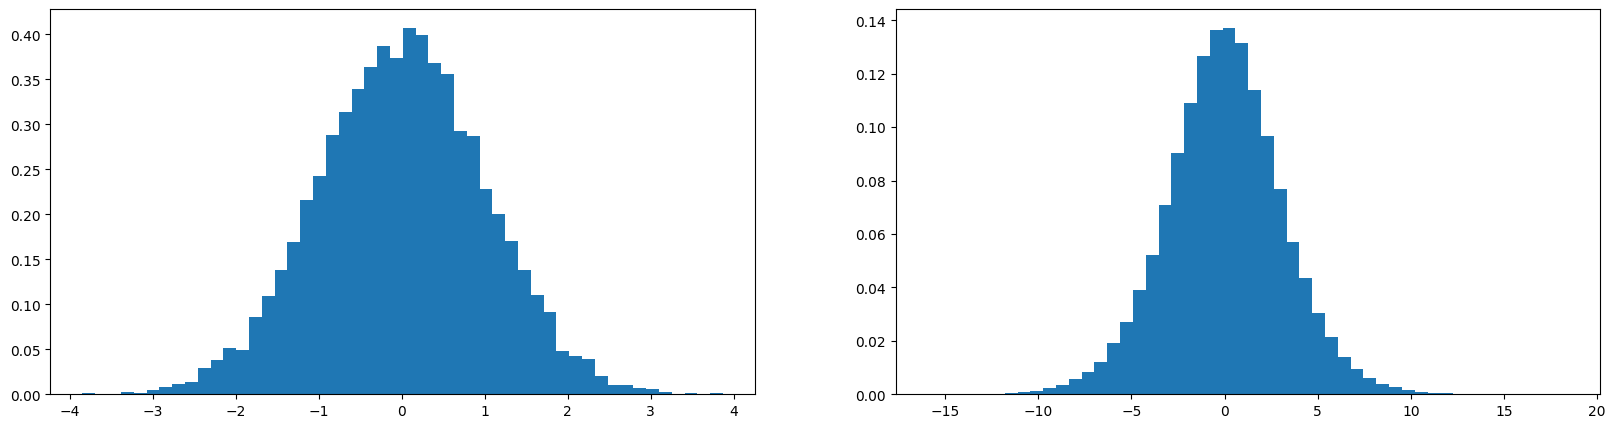

In [15]:
x = torch.randn(1000, 10)
w = torch.randn(10, 200)
y = x @ w
print(x.mean(), x.std())
print(y.mean(), y.std())
plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density=True)
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density=True)

Mathematically, we need to devide by the square root of the number of inputs. So in w, there are 10 inputs -> sqrt(10)

tensor(0.0038) tensor(0.9903)
tensor(0.0021) tensor(0.9697)


(array([2.16246038e-05, 0.00000000e+00, 2.16246038e-05, 0.00000000e+00,
        2.16246038e-05, 4.32492076e-05, 1.08123019e-04, 2.81119849e-04,
        2.81119849e-04, 9.29857963e-04, 1.12447940e-03, 2.09758657e-03,
        3.22206597e-03, 5.49264936e-03, 1.06609297e-02, 1.53534687e-02,
        2.60792722e-02, 4.14976147e-02, 6.48954360e-02, 9.58618686e-02,
        1.39370571e-01, 1.90685756e-01, 2.59733116e-01, 3.25753032e-01,
        3.83231228e-01, 4.26156067e-01, 4.41639283e-01, 4.22458260e-01,
        3.74084021e-01, 3.10918553e-01, 2.38692377e-01, 1.75635032e-01,
        1.28125777e-01, 8.44440778e-02, 5.74998215e-02, 3.79944289e-02,
        2.36140673e-02, 1.48777274e-02, 9.55807488e-03, 5.49264936e-03,
        2.91932151e-03, 1.98946355e-03, 9.94731775e-04, 3.67618265e-04,
        3.45993661e-04, 1.08123019e-04, 1.29747623e-04, 4.32492076e-05,
        2.16246038e-05, 4.32492076e-05]),
 array([-6.0969758 , -5.86575769, -5.63453959, -5.40332148, -5.17210337,
        -4.94088526, 

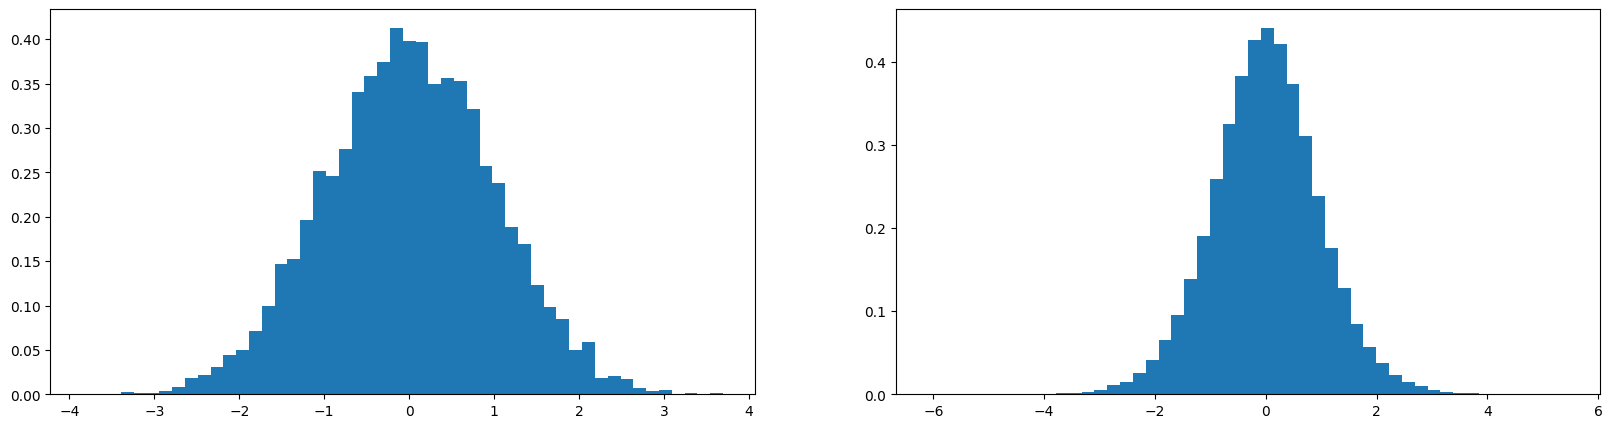

In [16]:
x = torch.randn(1000, 10)
w = torch.randn(10, 200) / 10**(1/2)
y = x @ w
print(x.mean(), x.std())
print(y.mean(), y.std())
plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density=True)
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density=True)

With Kaiming init, we know that the exact initialization for a tanh is 5/3 / (n)**1/2

In [17]:
# Note: n is n_embd * block_size

n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3) / ((n_embd * block_size)**(1/2))
b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0

parameters = [C, W1, W2, b2]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

11697


In [18]:
# same optimization as last time
max_steps = 20000
batch_size = 32
lossi = []

for i in range(max_steps):

    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

    # forward pass
    emb = C[Xb] # embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors

    # Linear layer
    # hidden pre-activation
    hpreact = embcat @ W1 + b1 # hidden layer pre-activation
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # loss function

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < max_steps //2 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 5000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

    #break

      0/  20000: 3.3179
   5000/  20000: 2.2421
  10000/  20000: 2.1928
  15000/  20000: 1.9397


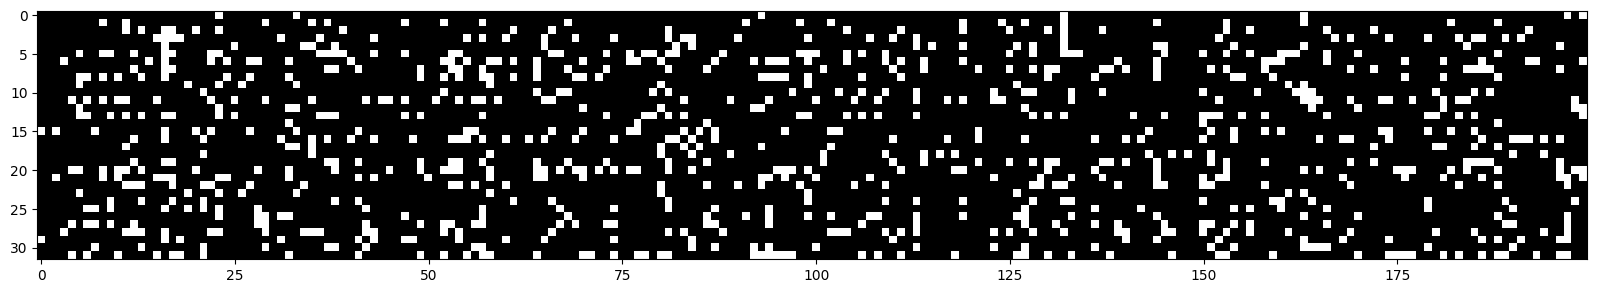

In [19]:
# 32 examples (y-axis) and 200 hidden neurons (x-axis)
# White: tanh neuron is very active and is in a flat tail (either at the top or the bottom).
# Backward gradient gets destroyed.
plt.figure(figsize=(20, 15))
plt.imshow(h.abs() > 0.99 , cmap='gray', interpolation='nearest')

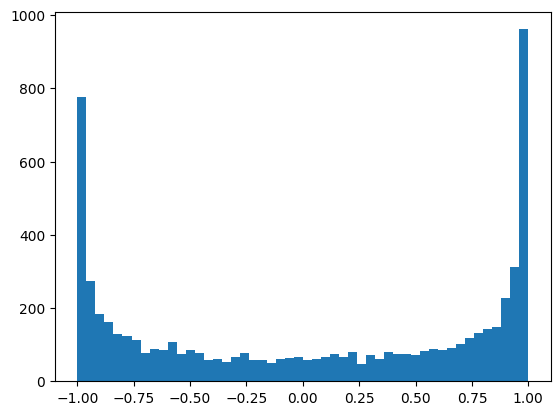

In [20]:
plt.hist(h.view(-1).tolist(), bins=50);

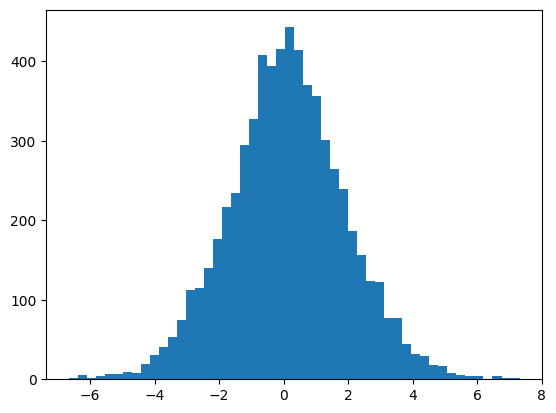

In [21]:
plt.hist(hpreact.view(-1).tolist(), 50);

In [22]:
hpreact.shape

torch.Size([32, 200])

In [23]:
hpreact.mean(dim=0, keepdim=True).shape

torch.Size([1, 200])

In [24]:
hpreact.std(dim=0, keepdim=True).shape

torch.Size([1, 200])

## Batch Normalization

In [25]:
# Note: n is n_embd * block_size

n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3) / ((n_embd * block_size)**(1/2))
b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0

bn_gain = torch.ones((1, n_hidden))
bn_bias = torch.zeros((1, n_hidden))

# At init, the mean will be ~0 and the std ~1
bn_mean_running = torch.zeros((1, n_hidden))
bn_std_running = torch.ones((1, n_hidden))

parameters = [C, W1, W2, b2, bn_gain, bn_bias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

12097


In [26]:
# same optimization as last time
max_steps = 20000
batch_size = 32
lossi = []

for i in range(max_steps):

    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

    # forward pass
    emb = C[Xb] # embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors

    # Linear layer
    # hidden pre-activation
    hpreact = embcat @ W1 + b1 # hidden layer pre-activation

    # Batch Norm
    bn_mean_i = hpreact.mean(dim=0, keepdims=True)
    bn_std_i = hpreact.std(dim=0, keepdims=True)
    hpreact = bn_gain * (hpreact - bn_mean_i) / bn_std_i + bn_bias

    # Smooth running mean/std updates
    with torch.no_grad():
        factor: float = 0.999
        bn_mean_running = factor * bn_mean_running + (1 - factor) * bn_mean_i
        bn_std_running = factor * bn_std_running + (1 - factor) * bn_std_i

    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # loss function

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < max_steps //2 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 5000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

    #break

      0/  20000: 3.3147
   5000/  20000: 2.3550
  10000/  20000: 2.1984
  15000/  20000: 2.1473


In [27]:
# Calibration of batch norm statistics
with torch.no_grad():
    # pass the training set through
    emb = C[Xtr]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1

    # Measure mean/std over the full training set
    bn_mean = hpreact.mean(dim=0, keepdims=True)
    bn_std = hpreact.std(dim=0, keepdims=True)

In [28]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
    x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
    }[split]
    emb = C[x] # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)

    hpreact = embcat @ W1 + b1

    # Batch Norm -> Using data computed over the full Training Set
    hpreact = bn_gain * (hpreact - bn_mean) / bn_std + bn_bias

    h = torch.tanh(hpreact) # (N, n_hidden)
    logits = h @ W2 + b2 # (N, vocab_size)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.1883440017700195
val 2.196559429168701


## Rearranging the code

In [29]:
# Note: n is n_embd * block_size

n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3) / ((n_embd * block_size)**(1/2))
b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0

bn_gain = torch.ones((1, n_hidden))
bn_bias = torch.zeros((1, n_hidden))

# At init, the mean will be ~0 and the std ~1
bn_mean_running = torch.zeros((1, n_hidden))
bn_std_running = torch.ones((1, n_hidden))

parameters = [C, W1, W2, b2, bn_gain, bn_bias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

12097


In [30]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  # Linear layer
  hpreact = embcat @ W1 #+ b1 # hidden layer pre-activation
  # BatchNorm layer
  # -------------------------------------------------------------
  bnmeani = hpreact.mean(0, keepdim=True)
  bnstdi = hpreact.std(0, keepdim=True)
  hpreact = bn_gain * (hpreact - bnmeani) / bnstdi + bn_bias
  with torch.no_grad():
    bn_mean_running = 0.999 * bn_mean_running + 0.001 * bnmeani
    bn_std_running = 0.999 * bn_std_running + 0.001 * bnstdi
  # -------------------------------------------------------------
  # Non-linearity
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

      0/ 200000: 3.3147
  10000/ 200000: 2.1984
  20000/ 200000: 2.3375
  30000/ 200000: 2.4359
  40000/ 200000: 2.0119
  50000/ 200000: 2.2595
  60000/ 200000: 2.4775
  70000/ 200000: 2.1020
  80000/ 200000: 2.2788
  90000/ 200000: 2.1862
 100000/ 200000: 1.9474
 110000/ 200000: 2.3010
 120000/ 200000: 1.9837
 130000/ 200000: 2.4523
 140000/ 200000: 2.3839
 150000/ 200000: 2.1987
 160000/ 200000: 1.9733
 170000/ 200000: 1.8668
 180000/ 200000: 1.9973
 190000/ 200000: 1.8347


## PyTorch

In [41]:
# The classes we create here are the same API as nn.Module in PyTorch

class Linear:

    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])


class BatchNorm1d:

    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # parameters (trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # buffers (trained with a running 'momentum update')
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        # calculate the forward pass
        if self.training:
            xmean = x.mean(dim=0, keepdim=True) # batch mean
            xvar = x.var(dim=0, keepdim=True) # batch variance
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
        self.out = self.gamma * xhat + self.beta
        # update the buffers
        if self.training:
            #Use the context manager to avoid computing the gradients on the below tensors
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out

    def parameters(self):
        return [self.gamma, self.beta]

class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return []

n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 100 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647) # for reproducibility

C = torch.randn((vocab_size, n_embd),            generator=g)
layers = [
    Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, vocab_size, bias=False), BatchNorm1d(vocab_size),
]
# layers = [
#   Linear(n_embd * block_size, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, vocab_size),
# ]

with torch.no_grad():
    # last layer: make less confident
    layers[-1].gamma *= 0.1
    #layers[-1].weight *= 0.1
    # all other layers: apply gain
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

47024


In [42]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):

    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

    # forward pass
    emb = C[Xb] # embed the characters into vectors
    x = emb.view(emb.shape[0], -1) # concatenate the vectors
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb) # loss function

    # backward pass
    for layer in layers:
        layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    with torch.no_grad():
        ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

    if i >= 1000:
        break # AFTER_DEBUG: would take out obviously to run full optimization

      0/ 200000: 3.2870


layer 2 (      Tanh): mean -0.00, std 0.63, saturated: 2.62%
layer 5 (      Tanh): mean +0.00, std 0.64, saturated: 2.47%
layer 8 (      Tanh): mean -0.00, std 0.64, saturated: 2.16%
layer 11 (      Tanh): mean +0.00, std 0.65, saturated: 1.81%
layer 14 (      Tanh): mean -0.00, std 0.65, saturated: 1.78%


Text(0.5, 1.0, 'activation distribution')

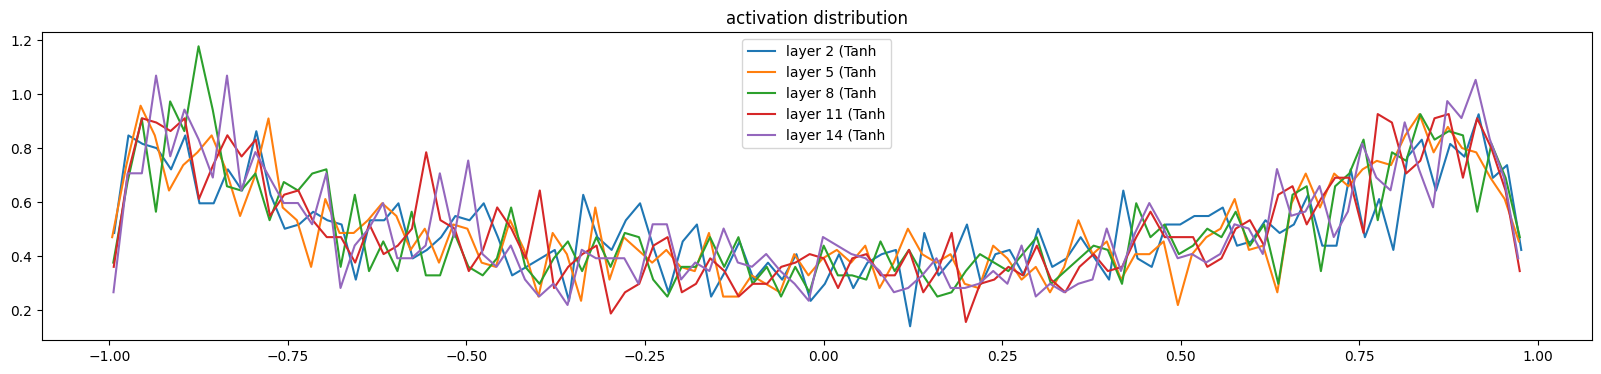

In [43]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
    if isinstance(layer, Tanh):
        t = layer.out
        print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

layer 2 (      Tanh): mean +0.000000, std 3.682960e-03
layer 5 (      Tanh): mean -0.000000, std 3.262612e-03
layer 8 (      Tanh): mean +0.000000, std 2.973734e-03
layer 11 (      Tanh): mean -0.000000, std 2.741114e-03
layer 14 (      Tanh): mean +0.000000, std 2.584296e-03


Text(0.5, 1.0, 'gradient distribution')

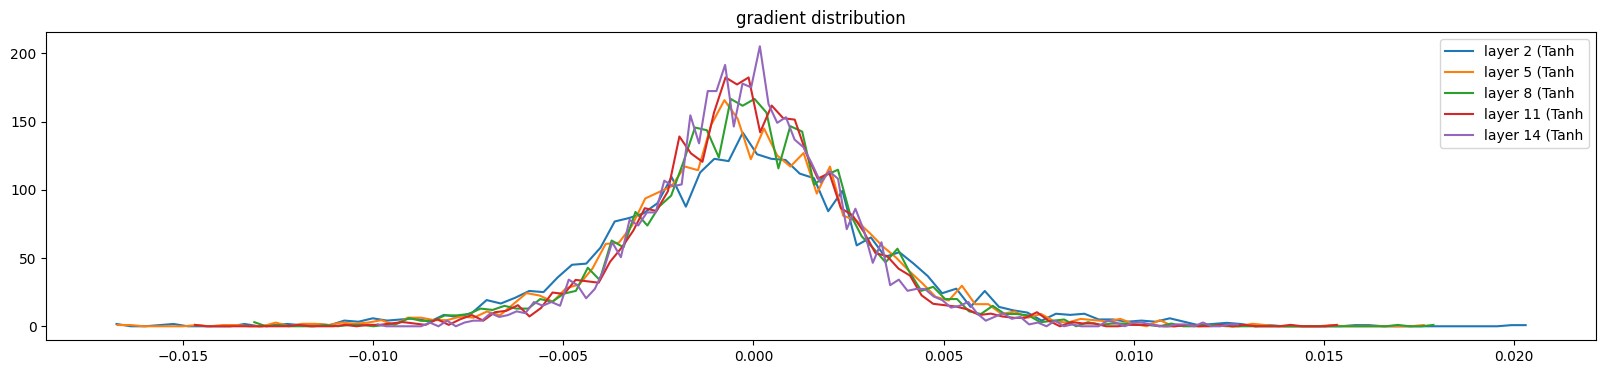

In [44]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
    if isinstance(layer, Tanh):
        t = layer.out.grad
        print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

weight   (27, 10) | mean -0.000000 | std 1.019889e-02 | grad:data ratio 1.018849e-02
weight  (30, 100) | mean +0.000092 | std 8.238442e-03 | grad:data ratio 2.635843e-02
weight (100, 100) | mean +0.000031 | std 7.318123e-03 | grad:data ratio 4.377151e-02
weight (100, 100) | mean -0.000019 | std 6.662030e-03 | grad:data ratio 3.949900e-02
weight (100, 100) | mean -0.000019 | std 5.821521e-03 | grad:data ratio 3.468164e-02
weight (100, 100) | mean +0.000053 | std 5.445303e-03 | grad:data ratio 3.243371e-02
weight  (100, 27) | mean -0.000165 | std 1.046846e-02 | grad:data ratio 6.281273e-02


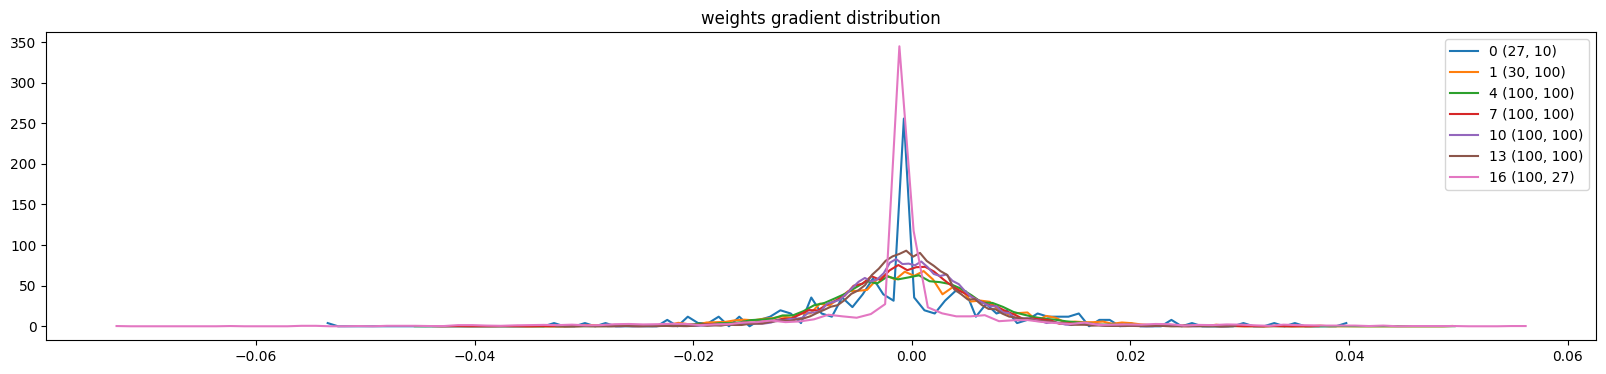

In [45]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
    t = p.grad
    if p.ndim == 2:
        print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

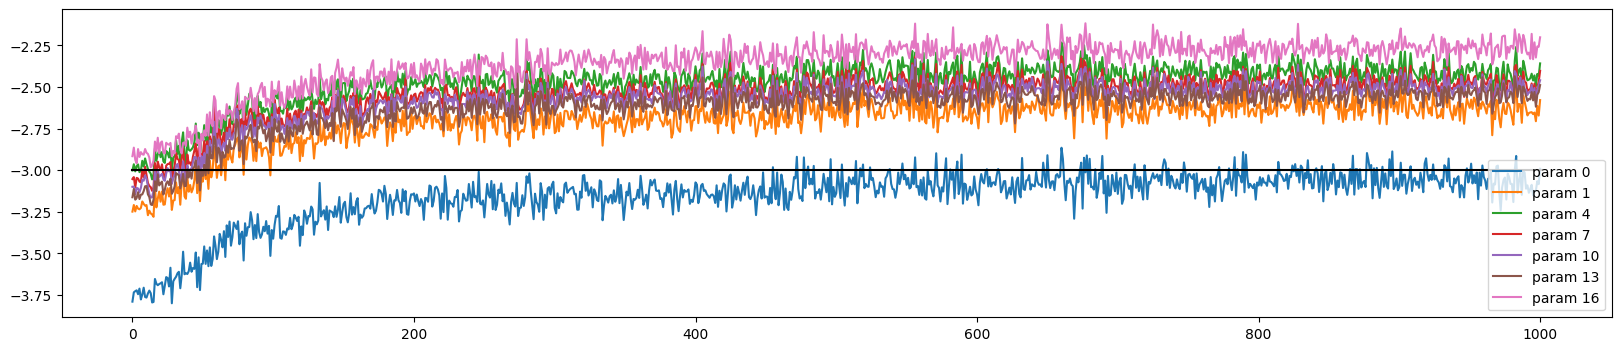

In [46]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
    if p.ndim == 2:
        plt.plot([ud[j][i] for j in range(len(ud))])
        legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);

In [47]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
    x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
    }[split]
    emb = C[x] # (N, block_size, n_embd)
    x = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, y)
    print(split, loss.item())

# put layers into eval mode
for layer in layers:
    layer.training = False
split_loss('train')
split_loss('val')

train 2.434417963027954
val 2.4324371814727783


In [48]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

    out = []
    context = [0] * block_size # initialize with all ...
    while True:
        # forward pass the neural net
        emb = C[torch.tensor([context])] # (1,block_size,n_embd)
        x = emb.view(emb.shape[0], -1) # concatenate the vectors
        for layer in layers:
            x = layer(x)
        logits = x
        probs = F.softmax(logits, dim=1)
        # sample from the distribution
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        # shift the context window and track the samples
        context = context[1:] + [ix]
        out.append(ix)
        # if we sample the special '.' token, break
        if ix == 0:
            break

    print(''.join(itos[i] for i in out)) # decode and print the generated word

mrianamyan.
seen.
ndhnyalarethrstendrleg.
adeeed.
eliileli.
jen.
ekein.
ananar.
katzimhltea.
n.
shdbvrgshiries.
kin.
reneliqxnthuoriu.
marede.
jymari.
ehs.
karjansanyan.
hal.
salyansui.
zajelveuren.
